In [2]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import os
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.io import read_image

class Birds270Dataset(Dataset):
    def make_labels(self, csv_table):
        bird_str_labels = csv_table["labels"].unique()
        self.labels_str_to_int = {label:i  for i, label in enumerate(bird_str_labels)}
        self.labels_int_to_str = {i:label  for i, label in enumerate(bird_str_labels)}
        
    def __init__(self, dataset_dir, set_type="train", transform=None, selected_birds=None):
        csv_table = pd.read_csv(os.path.join(dataset_dir, "birds.csv"))
        if selected_birds != None:
            csv_table = csv_table[csv_table["labels"].isin(selected_birds)]
        self.img_data = csv_table[csv_table["data set"]==set_type]
        self.make_labels(self.img_data)
        self.dataset_dir = dataset_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, idx):
        filepaths_col = self.img_data.columns.get_loc("filepaths")
        labels_col = self.img_data.columns.get_loc("labels")
        img_path = os.path.join(self.dataset_dir, self.img_data.iat[idx, filepaths_col])
        image = read_image(img_path).float()
        label = self.img_data.iat[idx, labels_col]
        if self.transform:
            image = self.transform(image)
        int_label = self.labels_str_to_int[label]
        return image, int_label
    



In [3]:
def make2d(int_or_tuple):
    if(type(int_or_tuple) is int):
        return (int_or_tuple,int_or_tuple)
    else:
        return int_or_tuple
# Returns the dimensions of the image after performing nn.Conv2d
def dim_conv2d(size_in, kernel_size, stride=1, padding=0, dilation=1):
    kernel_size = make2d(kernel_size)
    stride = make2d(stride)
    padding = make2d(padding)
    dilation = make2d(dilation)
    height_out = int((size_in[0] + 2*padding[0] - dilation[0]*(kernel_size[0]-1) - 1)/stride[0] + 1)
    width_out = int((size_in[1] + 2*padding[1] - dilation[1]*(kernel_size[1]-1) - 1)/stride[1] + 1)
    return (height_out, width_out)

# Returns the dimensions of the image after performing nn.MaxPool2d
def dim_maxpool2d(size_in, kernel_size, stride=None, padding=0, dilation=1):
    if stride == None:
        stride = kernel_size
    # The formula is the same as for dim_conv2d
    return dim_conv2d(size_in, kernel_size, stride=stride, padding=padding, dilation=dilation)


In [19]:
dataset_dir = "../data/birds270"
selected_birds = ["ALBATROSS", "BALD EAGLE", "BARN OWL", "EURASIAN MAGPIE", "FLAMINGO",
                  "MALLARD DUCK", "OSTRICH", "PEACOCK", "PELICAN", "TRUMPTER SWAN"]
tr = transforms.Normalize((127.5, 127.5, 127.5), (127.5, 127.5, 127.5)) # normalizes colors to range [-1,1]
train_dataset = Birds270Dataset(dataset_dir, set_type="train", selected_birds=selected_birds, transform=tr)
test_dataset = Birds270Dataset(dataset_dir, set_type="test", selected_birds=selected_birds, transform=tr)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import datetime

kernel_size = 5

def conv_out_size(height, width):
    dim = (height, width)
    dim = dim_conv2d(dim, kernel_size)
    dim = dim_maxpool2d(dim, 2, 2)
    dim = dim_conv2d(dim, kernel_size)
    dim = dim_maxpool2d(dim, 2, 2)
    return dim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size)
        conv_height, conv_width = conv_out_size(224, 224)
        self.fc1 = nn.Linear(16 * conv_width * conv_height, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train(net, train_dataloader, criterion, optimizer, device="cpu"):
    net.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        loss.backward()
        optimizer.step()
    epoch_loss = running_loss / len(train_dataloader.dataset)
    return {"loss":epoch_loss}

def evaluate(net, test_dataloader, criterion, device="cpu"):
    net.eval()
    correct = 0
    total = 0
    correct_labels = {label_str: 0 for label_str in test_dataset.labels_str_to_int.keys()}
    total_labels = {label_str: 0 for label_str in test_dataset.labels_str_to_int.keys()}
    running_loss = 0
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            for label, prediction in zip(labels, predicted):
                if label == prediction:
                    correct_labels[test_dataset.labels_int_to_str[label.item()]] += 1
                total_labels[test_dataset.labels_int_to_str[label.item()]] += 1
    epoch_loss = running_loss / len(test_dataloader.dataset)
    return {"correct":correct, "total":total, "loss":epoch_loss, "correct_labels":correct_labels, "total_labels":total_labels}

def print_label_accuracy(correct_labels, total_labels):
    for label_str, correct_label in correct_labels.items():
        total_label = total_labels[label_str]
        print(f"\t{label_str}: {100 * correct_label / total_label}")
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer  = optim.Adam(net.parameters())

for epoch in range(30):
    start_time = datetime.datetime.now()
    train_results = train(net, train_dataloader, criterion, optimizer, device=device)
    results = evaluate(net, test_dataloader, criterion, device=device)
    time_elapsed = datetime.datetime.now() - start_time
    train_loss = train_results["loss"]
    val_loss = results["loss"]
    accuracy = results["correct"]/results["total"]
    print(f"Epoch {epoch}:")
    print(f"\ttrain loss: {train_loss}")
    print(f"\tvalidation loss: {val_loss}, validation accuracy: {100 * accuracy}%")
    print(f"\tElapsed time: {time_elapsed}")

final_results = evaluate(net, test_dataloader, criterion, device=device)
final_loss = final_results["loss"]
final_accuracy = final_results["correct"]/final_results["total"]
print(f"Final loss: {final_loss}, final accuracy: {100*final_accuracy} %")
print_label_accuracy(final_results["correct_labels"], final_results["total_labels"])

torch.save(net, '../model/simple_DB_model.pth')
torch.save(net.state_dict(), '../model/simple_DB_model_weights.pth')


Device: cpu
Epoch 0:
	train loss: 1.792868981831906
	validation loss: 1.3655006790161133, validation accuracy: 62.0%
	Elapsed time: 0:00:11.788227
Epoch 1:
	train loss: 1.0449754547475891
	validation loss: 0.8494077110290528, validation accuracy: 68.0%
	Elapsed time: 0:00:11.837828
Epoch 2:
	train loss: 0.6267076301469368
	validation loss: 0.8043920588493347, validation accuracy: 76.0%
	Elapsed time: 0:00:11.262523
Epoch 3:
	train loss: 0.3287199141350691
	validation loss: 0.6342259645462036, validation accuracy: 80.0%
	Elapsed time: 0:00:11.009111
Epoch 4:
	train loss: 0.12769019976944082
	validation loss: 0.769259648323059, validation accuracy: 78.0%
	Elapsed time: 0:00:11.205052
Epoch 5:
	train loss: 0.026651078887250882
	validation loss: 0.9037971258163452, validation accuracy: 76.0%
	Elapsed time: 0:00:11.946251
Epoch 6:
	train loss: 0.006845809694171084
	validation loss: 0.9372232151031494, validation accuracy: 74.0%
	Elapsed time: 0:00:10.695022
Epoch 7:
	train loss: 0.001878676

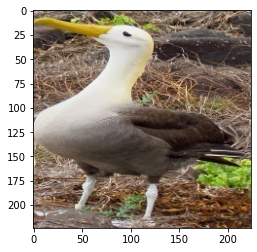

Label (number): 0, (name): ALBATROSS
BARN OWL: 68.38%
PEACOCK: 31.38%
ALBATROSS: 0.10%
FLAMINGO: 0.09%
BALD EAGLE: 0.03%
MALLARD DUCK: 0.01%
TRUMPTER SWAN: 0.01%
EURASIAN MAGPIE: 0.00%
OSTRICH: 0.00%
PELICAN: 0.00%


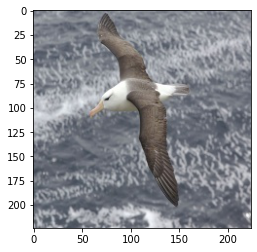

Label (number): 0, (name): ALBATROSS
ALBATROSS: 99.36%
TRUMPTER SWAN: 0.55%
PELICAN: 0.09%
EURASIAN MAGPIE: 0.00%
BALD EAGLE: 0.00%
PEACOCK: 0.00%
MALLARD DUCK: 0.00%
BARN OWL: 0.00%
FLAMINGO: 0.00%
OSTRICH: 0.00%


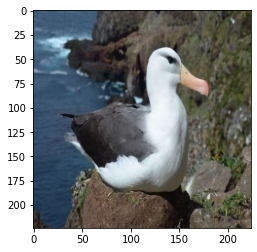

Label (number): 0, (name): ALBATROSS
ALBATROSS: 100.00%
PELICAN: 0.00%
TRUMPTER SWAN: 0.00%
EURASIAN MAGPIE: 0.00%
MALLARD DUCK: 0.00%
BALD EAGLE: 0.00%
OSTRICH: 0.00%
PEACOCK: 0.00%
BARN OWL: 0.00%
FLAMINGO: 0.00%


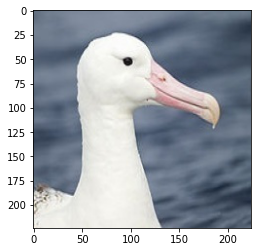

Label (number): 0, (name): ALBATROSS
TRUMPTER SWAN: 86.04%
ALBATROSS: 9.02%
PELICAN: 4.94%
FLAMINGO: 0.00%
BALD EAGLE: 0.00%
EURASIAN MAGPIE: 0.00%
OSTRICH: 0.00%
BARN OWL: 0.00%
PEACOCK: 0.00%
MALLARD DUCK: 0.00%


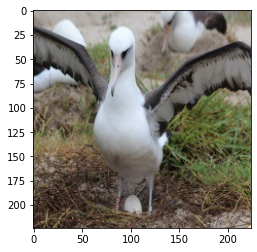

Label (number): 0, (name): ALBATROSS
ALBATROSS: 97.26%
PELICAN: 2.72%
EURASIAN MAGPIE: 0.01%
BARN OWL: 0.00%
TRUMPTER SWAN: 0.00%
BALD EAGLE: 0.00%
PEACOCK: 0.00%
MALLARD DUCK: 0.00%
OSTRICH: 0.00%
FLAMINGO: 0.00%


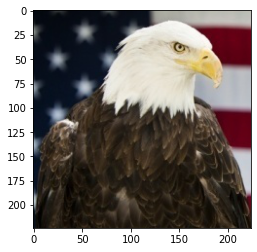

Label (number): 1, (name): BALD EAGLE
BALD EAGLE: 99.96%
BARN OWL: 0.04%
ALBATROSS: 0.00%
FLAMINGO: 0.00%
OSTRICH: 0.00%
PEACOCK: 0.00%
TRUMPTER SWAN: 0.00%
MALLARD DUCK: 0.00%
PELICAN: 0.00%
EURASIAN MAGPIE: 0.00%


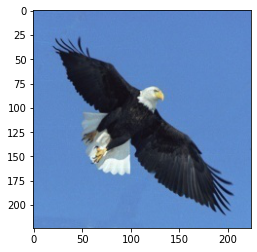

Label (number): 1, (name): BALD EAGLE
BALD EAGLE: 51.56%
EURASIAN MAGPIE: 48.43%
ALBATROSS: 0.01%
OSTRICH: 0.00%
TRUMPTER SWAN: 0.00%
MALLARD DUCK: 0.00%
PEACOCK: 0.00%
PELICAN: 0.00%
BARN OWL: 0.00%
FLAMINGO: 0.00%


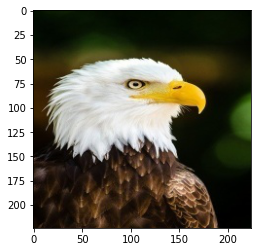

Label (number): 1, (name): BALD EAGLE
BARN OWL: 77.71%
FLAMINGO: 12.65%
BALD EAGLE: 8.83%
PELICAN: 0.81%
TRUMPTER SWAN: 0.00%
OSTRICH: 0.00%
PEACOCK: 0.00%
ALBATROSS: 0.00%
MALLARD DUCK: 0.00%
EURASIAN MAGPIE: 0.00%


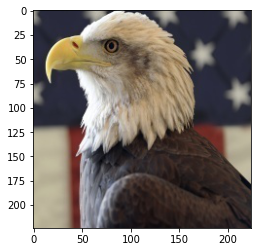

Label (number): 1, (name): BALD EAGLE
BARN OWL: 49.55%
FLAMINGO: 49.13%
BALD EAGLE: 1.25%
PEACOCK: 0.07%
OSTRICH: 0.00%
MALLARD DUCK: 0.00%
ALBATROSS: 0.00%
EURASIAN MAGPIE: 0.00%
PELICAN: 0.00%
TRUMPTER SWAN: 0.00%


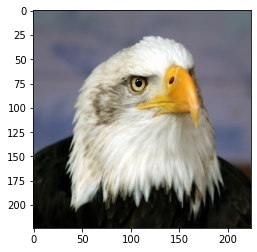

Label (number): 1, (name): BALD EAGLE
BALD EAGLE: 99.98%
PELICAN: 0.02%
TRUMPTER SWAN: 0.00%
BARN OWL: 0.00%
ALBATROSS: 0.00%
MALLARD DUCK: 0.00%
OSTRICH: 0.00%
FLAMINGO: 0.00%
EURASIAN MAGPIE: 0.00%
PEACOCK: 0.00%


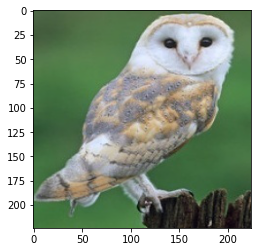

Label (number): 2, (name): BARN OWL
BARN OWL: 98.41%
BALD EAGLE: 1.40%
ALBATROSS: 0.16%
TRUMPTER SWAN: 0.01%
PELICAN: 0.01%
FLAMINGO: 0.01%
OSTRICH: 0.00%
MALLARD DUCK: 0.00%
PEACOCK: 0.00%
EURASIAN MAGPIE: 0.00%


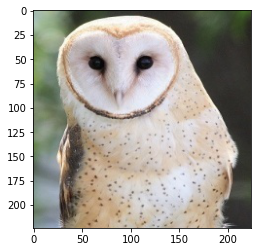

Label (number): 2, (name): BARN OWL
TRUMPTER SWAN: 87.42%
ALBATROSS: 7.96%
OSTRICH: 1.64%
PELICAN: 1.43%
FLAMINGO: 1.01%
BARN OWL: 0.30%
EURASIAN MAGPIE: 0.17%
BALD EAGLE: 0.06%
MALLARD DUCK: 0.00%
PEACOCK: 0.00%


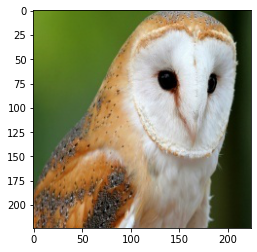

Label (number): 2, (name): BARN OWL
BARN OWL: 100.00%
TRUMPTER SWAN: 0.00%
PELICAN: 0.00%
ALBATROSS: 0.00%
FLAMINGO: 0.00%
OSTRICH: 0.00%
BALD EAGLE: 0.00%
MALLARD DUCK: 0.00%
PEACOCK: 0.00%
EURASIAN MAGPIE: 0.00%


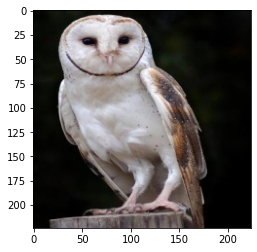

Label (number): 2, (name): BARN OWL
BARN OWL: 100.00%
BALD EAGLE: 0.00%
FLAMINGO: 0.00%
PELICAN: 0.00%
ALBATROSS: 0.00%
TRUMPTER SWAN: 0.00%
OSTRICH: 0.00%
PEACOCK: 0.00%
MALLARD DUCK: 0.00%
EURASIAN MAGPIE: 0.00%


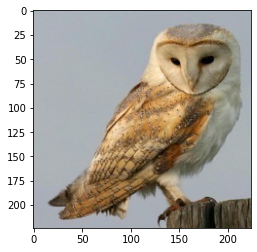

Label (number): 2, (name): BARN OWL
BARN OWL: 78.54%
FLAMINGO: 21.40%
OSTRICH: 0.05%
PELICAN: 0.01%
MALLARD DUCK: 0.00%
BALD EAGLE: 0.00%
ALBATROSS: 0.00%
TRUMPTER SWAN: 0.00%
EURASIAN MAGPIE: 0.00%
PEACOCK: 0.00%


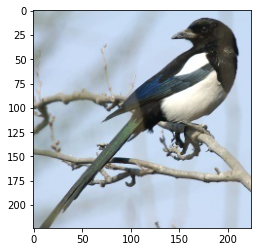

Label (number): 3, (name): EURASIAN MAGPIE
TRUMPTER SWAN: 60.72%
EURASIAN MAGPIE: 36.72%
ALBATROSS: 1.66%
PELICAN: 0.76%
BALD EAGLE: 0.07%
MALLARD DUCK: 0.04%
OSTRICH: 0.02%
FLAMINGO: 0.01%
PEACOCK: 0.01%
BARN OWL: 0.00%


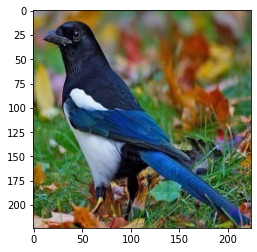

Label (number): 3, (name): EURASIAN MAGPIE
EURASIAN MAGPIE: 75.44%
MALLARD DUCK: 24.54%
BALD EAGLE: 0.01%
ALBATROSS: 0.01%
PEACOCK: 0.00%
OSTRICH: 0.00%
TRUMPTER SWAN: 0.00%
PELICAN: 0.00%
BARN OWL: 0.00%
FLAMINGO: 0.00%


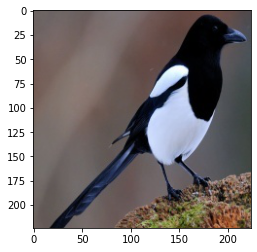

Label (number): 3, (name): EURASIAN MAGPIE
EURASIAN MAGPIE: 100.00%
ALBATROSS: 0.00%
OSTRICH: 0.00%
PELICAN: 0.00%
TRUMPTER SWAN: 0.00%
BALD EAGLE: 0.00%
MALLARD DUCK: 0.00%
PEACOCK: 0.00%
FLAMINGO: 0.00%
BARN OWL: 0.00%


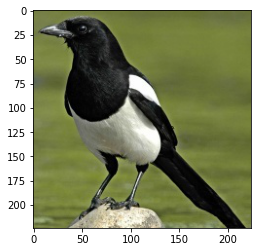

Label (number): 3, (name): EURASIAN MAGPIE
EURASIAN MAGPIE: 99.99%
OSTRICH: 0.01%
BALD EAGLE: 0.00%
ALBATROSS: 0.00%
MALLARD DUCK: 0.00%
PEACOCK: 0.00%
PELICAN: 0.00%
BARN OWL: 0.00%
TRUMPTER SWAN: 0.00%
FLAMINGO: 0.00%


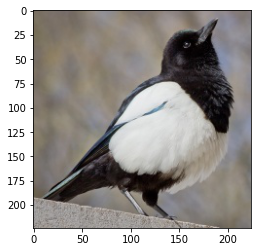

Label (number): 3, (name): EURASIAN MAGPIE
EURASIAN MAGPIE: 57.69%
PELICAN: 42.27%
TRUMPTER SWAN: 0.02%
ALBATROSS: 0.01%
FLAMINGO: 0.00%
OSTRICH: 0.00%
MALLARD DUCK: 0.00%
BALD EAGLE: 0.00%
PEACOCK: 0.00%
BARN OWL: 0.00%


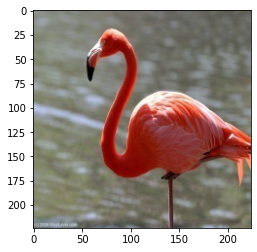

Label (number): 4, (name): FLAMINGO
FLAMINGO: 99.98%
BARN OWL: 0.01%
OSTRICH: 0.01%
MALLARD DUCK: 0.00%
PELICAN: 0.00%
PEACOCK: 0.00%
EURASIAN MAGPIE: 0.00%
ALBATROSS: 0.00%
BALD EAGLE: 0.00%
TRUMPTER SWAN: 0.00%


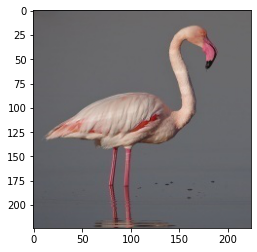

Label (number): 4, (name): FLAMINGO
FLAMINGO: 95.85%
PELICAN: 3.52%
MALLARD DUCK: 0.45%
BARN OWL: 0.06%
ALBATROSS: 0.06%
BALD EAGLE: 0.02%
TRUMPTER SWAN: 0.02%
PEACOCK: 0.01%
OSTRICH: 0.00%
EURASIAN MAGPIE: 0.00%


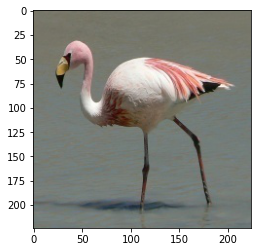

Label (number): 4, (name): FLAMINGO
FLAMINGO: 98.40%
PELICAN: 1.06%
TRUMPTER SWAN: 0.34%
BARN OWL: 0.09%
OSTRICH: 0.05%
MALLARD DUCK: 0.04%
BALD EAGLE: 0.01%
ALBATROSS: 0.01%
EURASIAN MAGPIE: 0.00%
PEACOCK: 0.00%


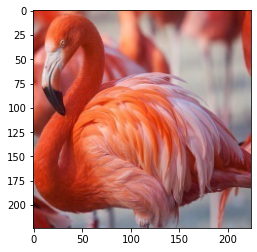

Label (number): 4, (name): FLAMINGO
FLAMINGO: 100.00%
BARN OWL: 0.00%
OSTRICH: 0.00%
MALLARD DUCK: 0.00%
PEACOCK: 0.00%
EURASIAN MAGPIE: 0.00%
PELICAN: 0.00%
BALD EAGLE: 0.00%
ALBATROSS: 0.00%
TRUMPTER SWAN: 0.00%


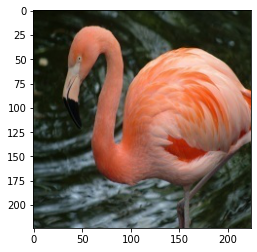

Label (number): 4, (name): FLAMINGO
FLAMINGO: 100.00%
BARN OWL: 0.00%
MALLARD DUCK: 0.00%
BALD EAGLE: 0.00%
PEACOCK: 0.00%
OSTRICH: 0.00%
PELICAN: 0.00%
TRUMPTER SWAN: 0.00%
ALBATROSS: 0.00%
EURASIAN MAGPIE: 0.00%


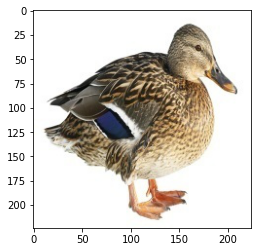

Label (number): 5, (name): MALLARD DUCK
MALLARD DUCK: 99.57%
OSTRICH: 0.43%
BARN OWL: 0.00%
BALD EAGLE: 0.00%
FLAMINGO: 0.00%
PEACOCK: 0.00%
EURASIAN MAGPIE: 0.00%
PELICAN: 0.00%
ALBATROSS: 0.00%
TRUMPTER SWAN: 0.00%


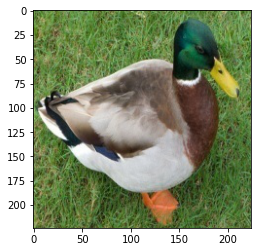

Label (number): 5, (name): MALLARD DUCK
MALLARD DUCK: 99.99%
ALBATROSS: 0.01%
EURASIAN MAGPIE: 0.00%
BALD EAGLE: 0.00%
TRUMPTER SWAN: 0.00%
OSTRICH: 0.00%
PELICAN: 0.00%
BARN OWL: 0.00%
PEACOCK: 0.00%
FLAMINGO: 0.00%


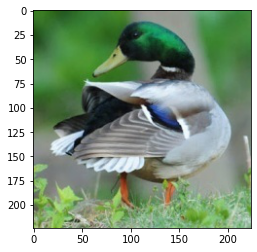

Label (number): 5, (name): MALLARD DUCK
PELICAN: 99.03%
EURASIAN MAGPIE: 0.87%
MALLARD DUCK: 0.06%
ALBATROSS: 0.02%
TRUMPTER SWAN: 0.01%
OSTRICH: 0.00%
FLAMINGO: 0.00%
PEACOCK: 0.00%
BALD EAGLE: 0.00%
BARN OWL: 0.00%


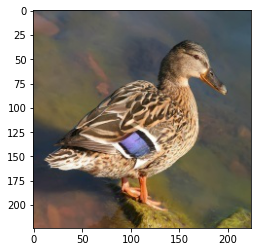

Label (number): 5, (name): MALLARD DUCK
MALLARD DUCK: 99.92%
PELICAN: 0.08%
FLAMINGO: 0.00%
OSTRICH: 0.00%
PEACOCK: 0.00%
BARN OWL: 0.00%
ALBATROSS: 0.00%
EURASIAN MAGPIE: 0.00%
BALD EAGLE: 0.00%
TRUMPTER SWAN: 0.00%


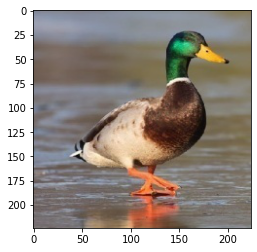

Label (number): 5, (name): MALLARD DUCK
MALLARD DUCK: 100.00%
OSTRICH: 0.00%
PELICAN: 0.00%
FLAMINGO: 0.00%
EURASIAN MAGPIE: 0.00%
BARN OWL: 0.00%
BALD EAGLE: 0.00%
ALBATROSS: 0.00%
PEACOCK: 0.00%
TRUMPTER SWAN: 0.00%


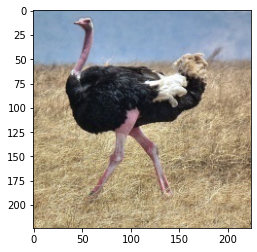

Label (number): 6, (name): OSTRICH
OSTRICH: 100.00%
EURASIAN MAGPIE: 0.00%
BARN OWL: 0.00%
MALLARD DUCK: 0.00%
BALD EAGLE: 0.00%
PEACOCK: 0.00%
ALBATROSS: 0.00%
FLAMINGO: 0.00%
PELICAN: 0.00%
TRUMPTER SWAN: 0.00%


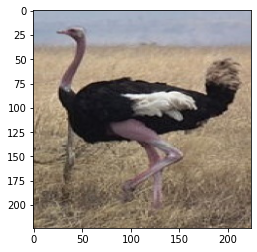

Label (number): 6, (name): OSTRICH
OSTRICH: 100.00%
EURASIAN MAGPIE: 0.00%
BALD EAGLE: 0.00%
MALLARD DUCK: 0.00%
BARN OWL: 0.00%
ALBATROSS: 0.00%
PELICAN: 0.00%
FLAMINGO: 0.00%
PEACOCK: 0.00%
TRUMPTER SWAN: 0.00%


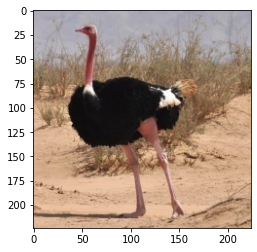

Label (number): 6, (name): OSTRICH
OSTRICH: 100.00%
EURASIAN MAGPIE: 0.00%
BARN OWL: 0.00%
BALD EAGLE: 0.00%
MALLARD DUCK: 0.00%
PEACOCK: 0.00%
FLAMINGO: 0.00%
ALBATROSS: 0.00%
PELICAN: 0.00%
TRUMPTER SWAN: 0.00%


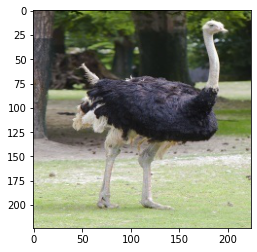

Label (number): 6, (name): OSTRICH
TRUMPTER SWAN: 99.91%
OSTRICH: 0.06%
EURASIAN MAGPIE: 0.02%
MALLARD DUCK: 0.01%
BALD EAGLE: 0.00%
PEACOCK: 0.00%
FLAMINGO: 0.00%
PELICAN: 0.00%
BARN OWL: 0.00%
ALBATROSS: 0.00%


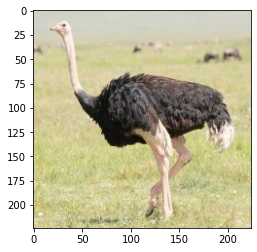

Label (number): 6, (name): OSTRICH
OSTRICH: 100.00%
EURASIAN MAGPIE: 0.00%
BARN OWL: 0.00%
BALD EAGLE: 0.00%
MALLARD DUCK: 0.00%
PEACOCK: 0.00%
FLAMINGO: 0.00%
ALBATROSS: 0.00%
PELICAN: 0.00%
TRUMPTER SWAN: 0.00%


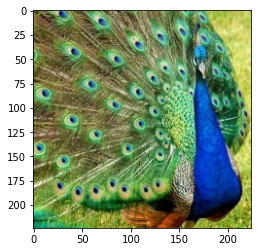

Label (number): 7, (name): PEACOCK
PEACOCK: 100.00%
EURASIAN MAGPIE: 0.00%
ALBATROSS: 0.00%
PELICAN: 0.00%
OSTRICH: 0.00%
MALLARD DUCK: 0.00%
BALD EAGLE: 0.00%
BARN OWL: 0.00%
TRUMPTER SWAN: 0.00%
FLAMINGO: 0.00%


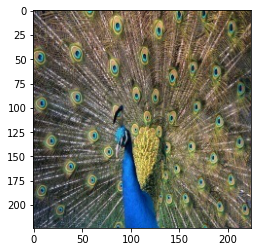

Label (number): 7, (name): PEACOCK
PEACOCK: 100.00%
BARN OWL: 0.00%
FLAMINGO: 0.00%
ALBATROSS: 0.00%
BALD EAGLE: 0.00%
MALLARD DUCK: 0.00%
OSTRICH: 0.00%
PELICAN: 0.00%
EURASIAN MAGPIE: 0.00%
TRUMPTER SWAN: 0.00%


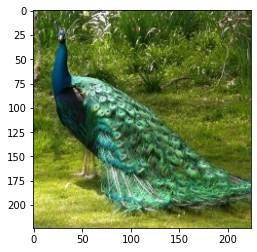

Label (number): 7, (name): PEACOCK
PEACOCK: 100.00%
EURASIAN MAGPIE: 0.00%
OSTRICH: 0.00%
ALBATROSS: 0.00%
BALD EAGLE: 0.00%
BARN OWL: 0.00%
PELICAN: 0.00%
TRUMPTER SWAN: 0.00%
FLAMINGO: 0.00%
MALLARD DUCK: 0.00%


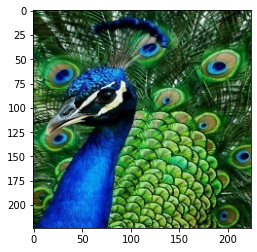

Label (number): 7, (name): PEACOCK
PEACOCK: 100.00%
ALBATROSS: 0.00%
OSTRICH: 0.00%
PELICAN: 0.00%
BALD EAGLE: 0.00%
BARN OWL: 0.00%
EURASIAN MAGPIE: 0.00%
TRUMPTER SWAN: 0.00%
MALLARD DUCK: 0.00%
FLAMINGO: 0.00%


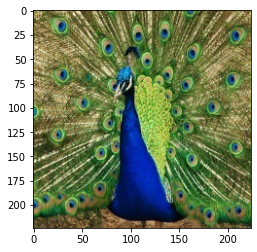

Label (number): 7, (name): PEACOCK
PEACOCK: 100.00%
BALD EAGLE: 0.00%
ALBATROSS: 0.00%
EURASIAN MAGPIE: 0.00%
MALLARD DUCK: 0.00%
BARN OWL: 0.00%
OSTRICH: 0.00%
TRUMPTER SWAN: 0.00%
FLAMINGO: 0.00%
PELICAN: 0.00%


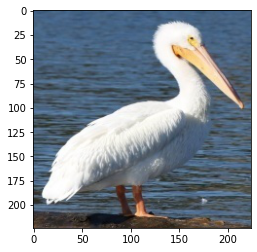

Label (number): 8, (name): PELICAN
TRUMPTER SWAN: 99.13%
ALBATROSS: 0.86%
PELICAN: 0.01%
BALD EAGLE: 0.00%
MALLARD DUCK: 0.00%
FLAMINGO: 0.00%
EURASIAN MAGPIE: 0.00%
BARN OWL: 0.00%
PEACOCK: 0.00%
OSTRICH: 0.00%


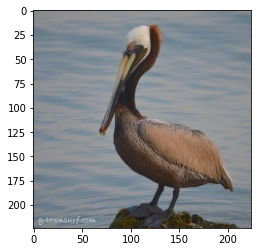

Label (number): 8, (name): PELICAN
BARN OWL: 74.92%
ALBATROSS: 12.83%
TRUMPTER SWAN: 5.21%
PELICAN: 4.27%
BALD EAGLE: 2.16%
OSTRICH: 0.34%
FLAMINGO: 0.21%
PEACOCK: 0.05%
MALLARD DUCK: 0.00%
EURASIAN MAGPIE: 0.00%


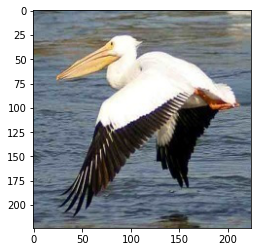

Label (number): 8, (name): PELICAN
PELICAN: 95.39%
EURASIAN MAGPIE: 2.89%
BALD EAGLE: 1.19%
ALBATROSS: 0.53%
OSTRICH: 0.00%
PEACOCK: 0.00%
MALLARD DUCK: 0.00%
TRUMPTER SWAN: 0.00%
FLAMINGO: 0.00%
BARN OWL: 0.00%


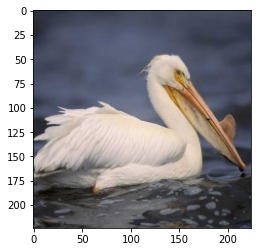

Label (number): 8, (name): PELICAN
TRUMPTER SWAN: 98.69%
PELICAN: 1.27%
BALD EAGLE: 0.02%
ALBATROSS: 0.02%
FLAMINGO: 0.00%
MALLARD DUCK: 0.00%
BARN OWL: 0.00%
OSTRICH: 0.00%
PEACOCK: 0.00%
EURASIAN MAGPIE: 0.00%


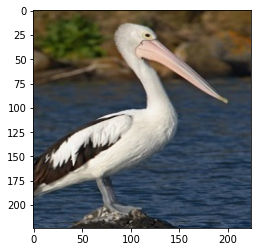

Label (number): 8, (name): PELICAN
BALD EAGLE: 79.63%
TRUMPTER SWAN: 11.88%
PELICAN: 8.20%
ALBATROSS: 0.29%
MALLARD DUCK: 0.00%
PEACOCK: 0.00%
EURASIAN MAGPIE: 0.00%
FLAMINGO: 0.00%
BARN OWL: 0.00%
OSTRICH: 0.00%


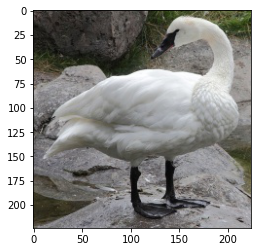

Label (number): 9, (name): TRUMPTER SWAN
TRUMPTER SWAN: 96.04%
ALBATROSS: 3.88%
PELICAN: 0.08%
BARN OWL: 0.00%
FLAMINGO: 0.00%
PEACOCK: 0.00%
BALD EAGLE: 0.00%
MALLARD DUCK: 0.00%
EURASIAN MAGPIE: 0.00%
OSTRICH: 0.00%


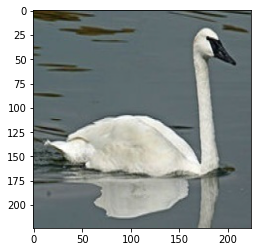

Label (number): 9, (name): TRUMPTER SWAN
TRUMPTER SWAN: 100.00%
PELICAN: 0.00%
ALBATROSS: 0.00%
MALLARD DUCK: 0.00%
FLAMINGO: 0.00%
BALD EAGLE: 0.00%
EURASIAN MAGPIE: 0.00%
BARN OWL: 0.00%
PEACOCK: 0.00%
OSTRICH: 0.00%


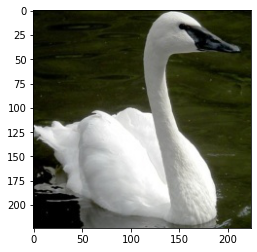

Label (number): 9, (name): TRUMPTER SWAN
TRUMPTER SWAN: 99.97%
ALBATROSS: 0.03%
PELICAN: 0.00%
BALD EAGLE: 0.00%
FLAMINGO: 0.00%
BARN OWL: 0.00%
PEACOCK: 0.00%
EURASIAN MAGPIE: 0.00%
MALLARD DUCK: 0.00%
OSTRICH: 0.00%


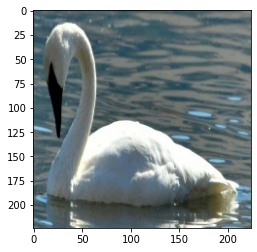

Label (number): 9, (name): TRUMPTER SWAN
TRUMPTER SWAN: 99.85%
ALBATROSS: 0.14%
MALLARD DUCK: 0.01%
PELICAN: 0.00%
BALD EAGLE: 0.00%
FLAMINGO: 0.00%
EURASIAN MAGPIE: 0.00%
BARN OWL: 0.00%
PEACOCK: 0.00%
OSTRICH: 0.00%


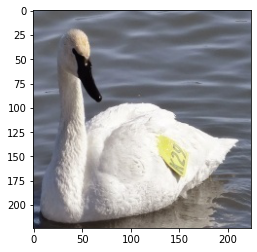

Label (number): 9, (name): TRUMPTER SWAN
TRUMPTER SWAN: 99.25%
PELICAN: 0.66%
ALBATROSS: 0.09%
EURASIAN MAGPIE: 0.00%
FLAMINGO: 0.00%
BALD EAGLE: 0.00%
MALLARD DUCK: 0.00%
OSTRICH: 0.00%
BARN OWL: 0.00%
PEACOCK: 0.00%


In [22]:
#function for displaying a picture
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def print_probs(prob_labels):
    for label, prob in prob_labels:
        print("{}: {:.2f}%".format(label, prob*100))

display_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
for data in display_dataloader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    img = images[0].squeeze()
    label = labels[0].item()
    imshow(img)
    label_str = test_dataset.labels_int_to_str[label]
    print(f"Label (number): {label}, (name): {label_str}")
    prob_tensor = nn.Softmax(dim=1)(outputs.data).squeeze()
    prob_list = prob_tensor.tolist()
    prob_labels = [(test_dataset.labels_int_to_str[i], prob) for i, prob in enumerate(prob_list)]
    prob_labels.sort(key = lambda t : t[1], reverse=True)
    print_probs(prob_labels)
    